In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix

ModuleNotFoundError: No module named 'xgboost'

In [3]:
df = pd.read_csv('uplift_synthetic_data_100trials.csv')

In [ ]:
!pip install xgboost

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 43 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   Unnamed: 0                  1000000 non-null  int64  
 1   trial_id                    1000000 non-null  int64  
 2   treatment_group_key         1000000 non-null  object 
 3   conversion                  1000000 non-null  int64  
 4   control_conversion_prob     1000000 non-null  float64
 5   treatment1_conversion_prob  1000000 non-null  float64
 6   treatment1_true_effect      1000000 non-null  float64
 7   x1_informative              1000000 non-null  float64
 8   x2_informative              1000000 non-null  float64
 9   x3_informative              1000000 non-null  float64
 10  x4_informative              1000000 non-null  float64
 11  x5_informative              1000000 non-null  float64
 12  x6_informative              1000000 non-null  float64
 13

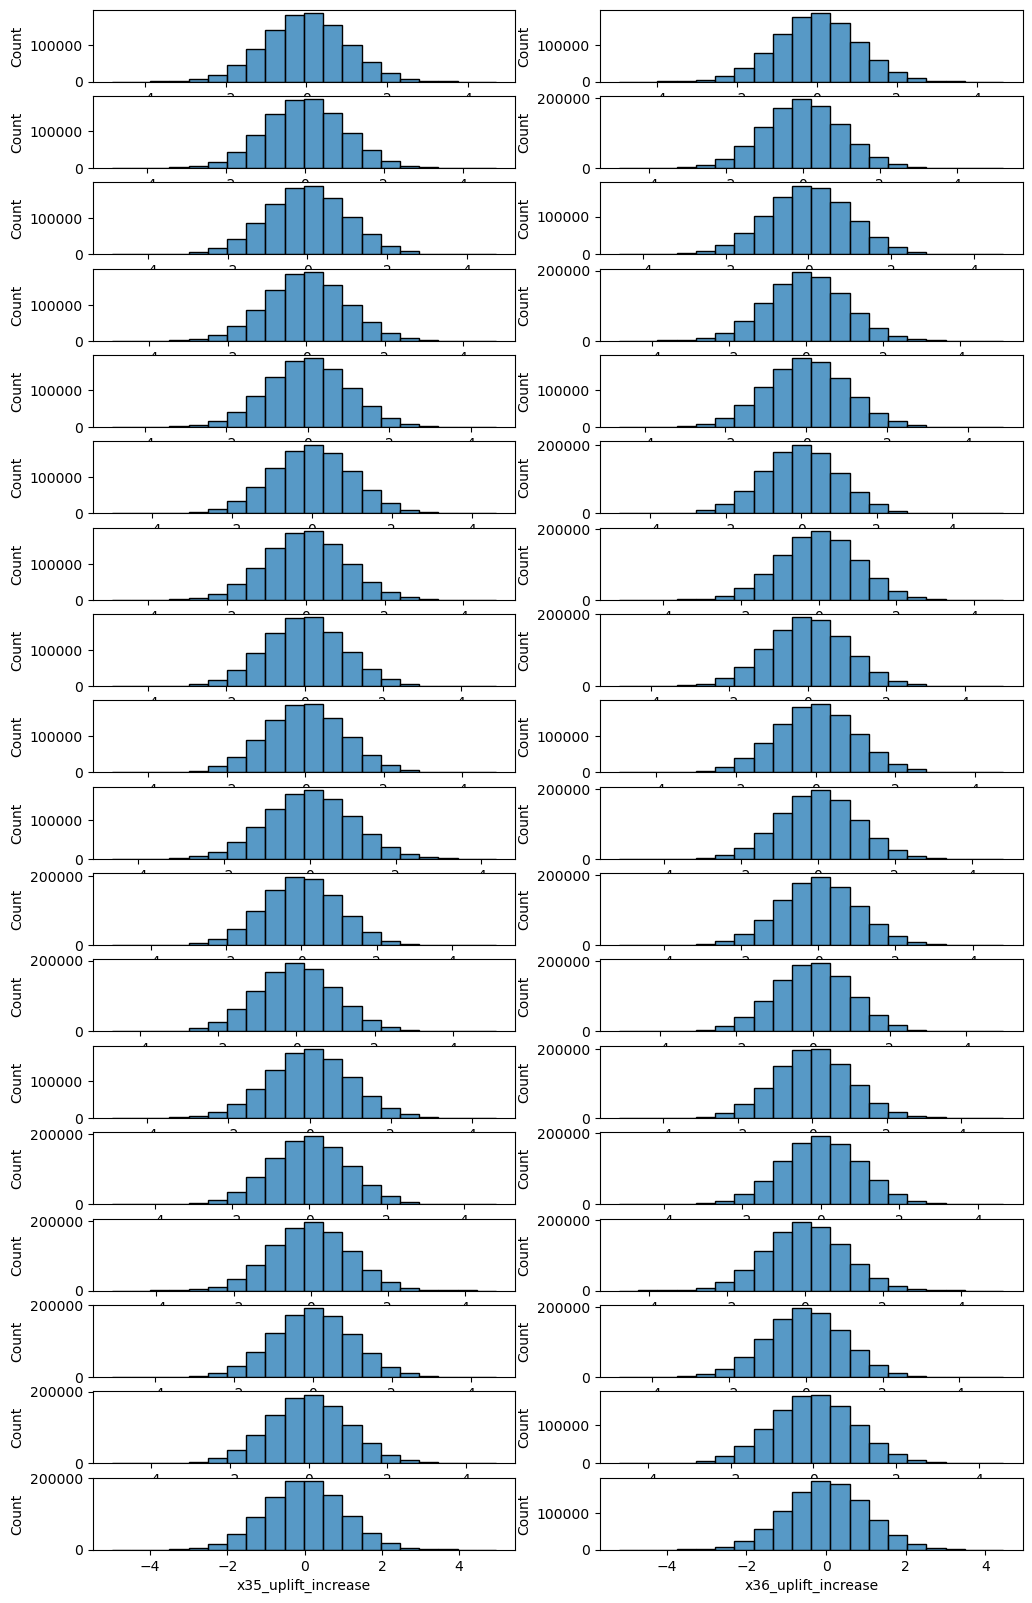

(       x1_informative  x2_informative  x3_informative  x4_informative  \
 count  1000000.000000  1000000.000000  1000000.000000  1000000.000000   
 mean        -0.001585        0.000352        0.001122        0.000614   
 std          0.999992        0.999010        1.000144        1.000122   
 min         -4.823255       -4.941324       -4.882931       -4.780078   
 25%         -0.675506       -0.674350       -0.674476       -0.673506   
 50%         -0.000660        0.000091       -0.000335       -0.000206   
 75%          0.672818        0.673720        0.675828        0.675615   
 max          4.700681        4.661994        4.842620        5.207952   
 
        x5_informative  x6_informative  x7_informative  x8_informative  \
 count  1000000.000000  1000000.000000  1000000.000000  1000000.000000   
 mean         0.000475       -0.000994        0.001797       -0.000817   
 std          1.000363        1.000269        1.000103        0.999026   
 min         -4.901258       -4.5786

In [10]:
customer_features = df.columns[df.columns.str.contains('x')]
customer_features_info = df[customer_features].describe()

group_counts = df['treatment_group_key'].value_counts()

plt.figure(figsize=(12, 20))
for index, feature in enumerate(customer_features):
    plt.subplot(len(customer_features) // 2 + len(customer_features) % 2, 2, index + 1)
    sns.histplot(df[feature], kde=False, bins=20)
plt.show()

customer_features_info, group_counts

In [11]:
informative_features = [col for col in df if 'informative' in col]
irrelevant_features = [col for col in df if 'irrelevant' in col]
uplift_features = [col for col in df if 'uplift_increase' in col]

informative_describe = df[informative_features].describe()

group_counts = df['treatment_group_key'].value_counts()


informative_describe, group_counts

(       x1_informative  x2_informative  x3_informative  x4_informative  \
 count  1000000.000000  1000000.000000  1000000.000000  1000000.000000   
 mean        -0.001585        0.000352        0.001122        0.000614   
 std          0.999992        0.999010        1.000144        1.000122   
 min         -4.823255       -4.941324       -4.882931       -4.780078   
 25%         -0.675506       -0.674350       -0.674476       -0.673506   
 50%         -0.000660        0.000091       -0.000335       -0.000206   
 75%          0.672818        0.673720        0.675828        0.675615   
 max          4.700681        4.661994        4.842620        5.207952   
 
        x5_informative  x6_informative  x7_informative  x8_informative  \
 count  1000000.000000  1000000.000000  1000000.000000  1000000.000000   
 mean         0.000475       -0.000994        0.001797       -0.000817   
 std          1.000363        1.000269        1.000103        0.999026   
 min         -4.901258       -4.5786

In [ ]:
X = df.drop(['conversion', 'trial_id', 'treatment_group_key'], axis=1)  # исключаем непризнаковые и целевую переменную
y = df['conversion']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

xgb_model = XGBClassifier(n_estimators=60, max_depth=3, use_label_encoder=False, eval_metric='logloss')

xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

roc_auc = roc_auc_score(y_test, y_pred)

fpr, tpr, thresholds = roc_curve(y_test, xgb_model.predict_proba(X_test)[:,1])

plt.figure()
plt.plot(fpr, tpr, label='XGBClassifier (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Вывод метрик
print('Confusion Matrix:\n', conf_matrix)
print('Precision: {:.2f}'.format(precision))
print('Recall: {:.2f}'.format(recall))
print('ROC AUC: {:.2f}'.format(roc_auc))